<a href="https://colab.research.google.com/github/roundspecs/error-bar-detection/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GDrive & GitHub

In [95]:
!git clone https://github.com/roundspecs/error-bar-detection.git error_bar_detection

Cloning into 'error_bar_detection'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 46 (delta 13), reused 37 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 8.26 KiB | 8.26 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [96]:
import os
os.chdir("/content/error_bar_detection")

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
from pathlib import Path
DATASET_PATH = Path('/content/drive/MyDrive/Delineate/data/raw')

# EDA

In [99]:
import os
from src.common.loader import load_dataset

dataset = load_dataset(DATASET_PATH)

In [100]:
print(dataset[0].image_path)

/content/drive/MyDrive/Delineate/data/raw/images/043d958d-c6fb-407e-ba05-19ccf09017a2.png


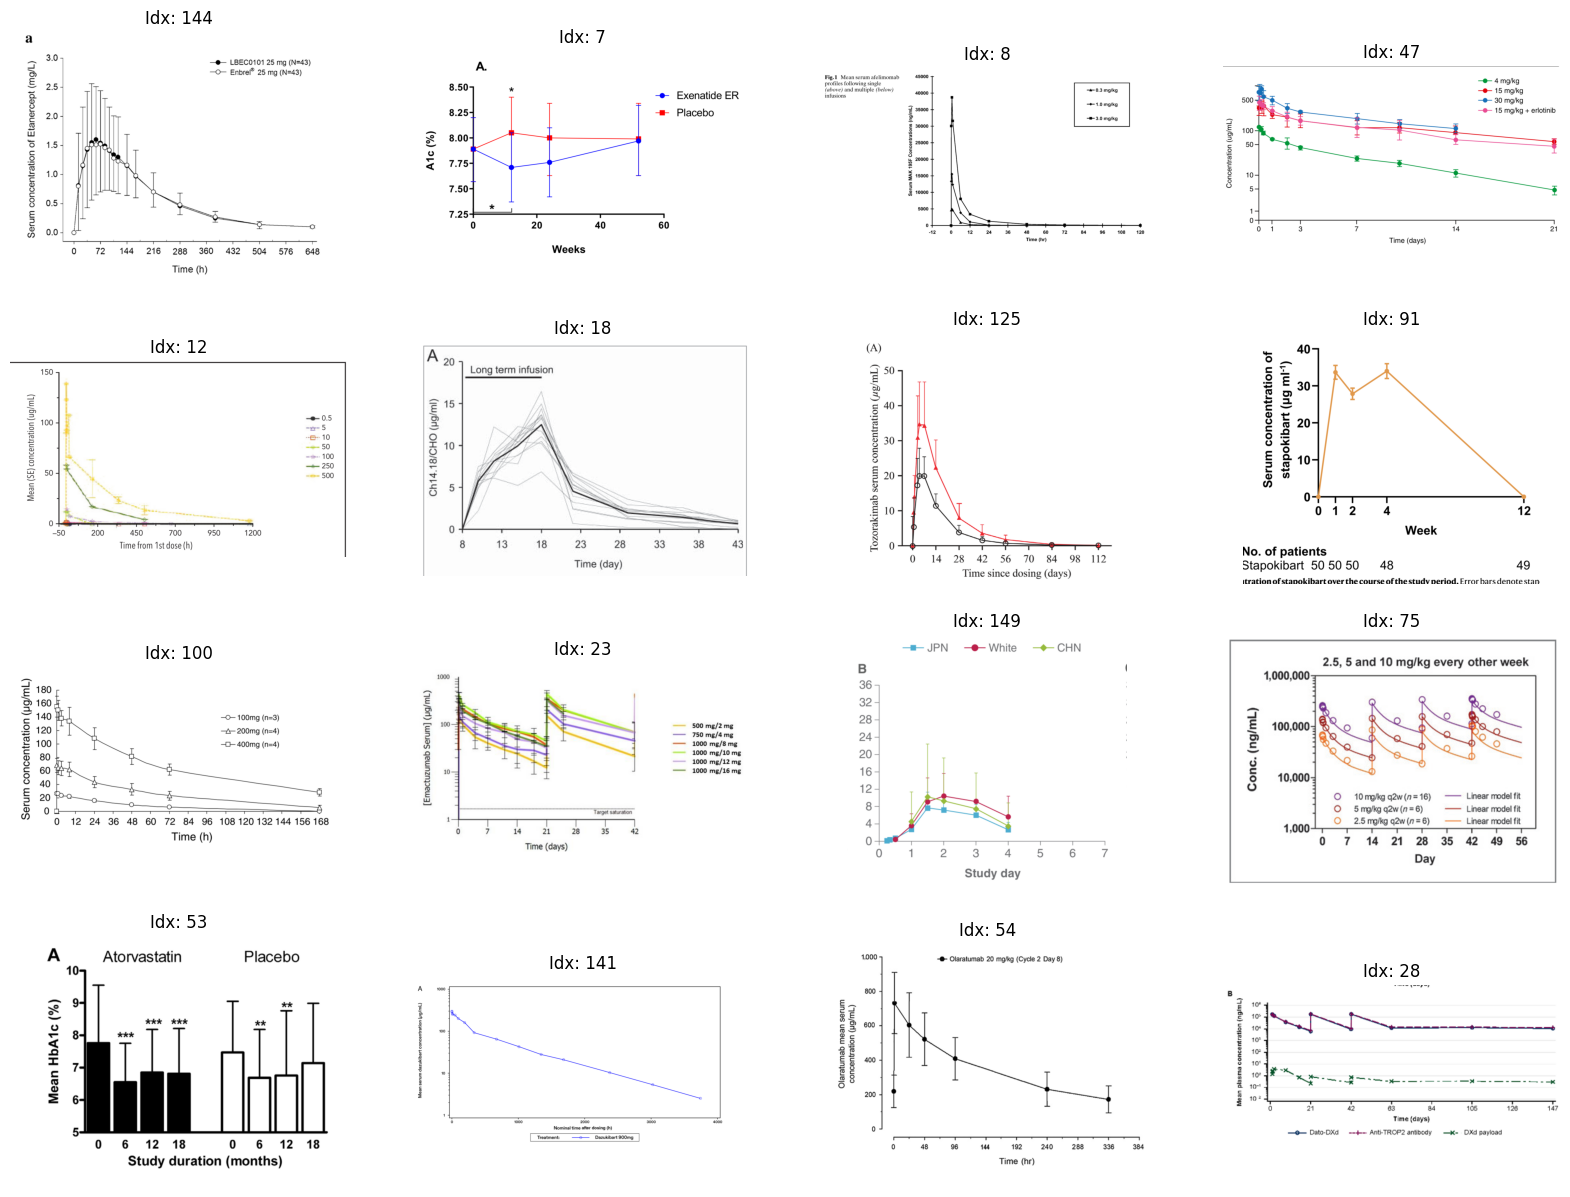

In [101]:
from matplotlib import pyplot as plt
import random

random_idx = [random.randint(0, len(dataset) - 1) for _ in range(16)]

fig, axs = plt.subplots(4, 4, figsize=(20, 15))
for i, idx in enumerate(random_idx):
  img = plt.imread(dataset[idx].image_path)
  axs[i%4][i//4].imshow(img)
  axs[i%4][i//4].set_title(f"Idx: {idx}")
  axs[i%4][i//4].set_axis_off()
plt.show()

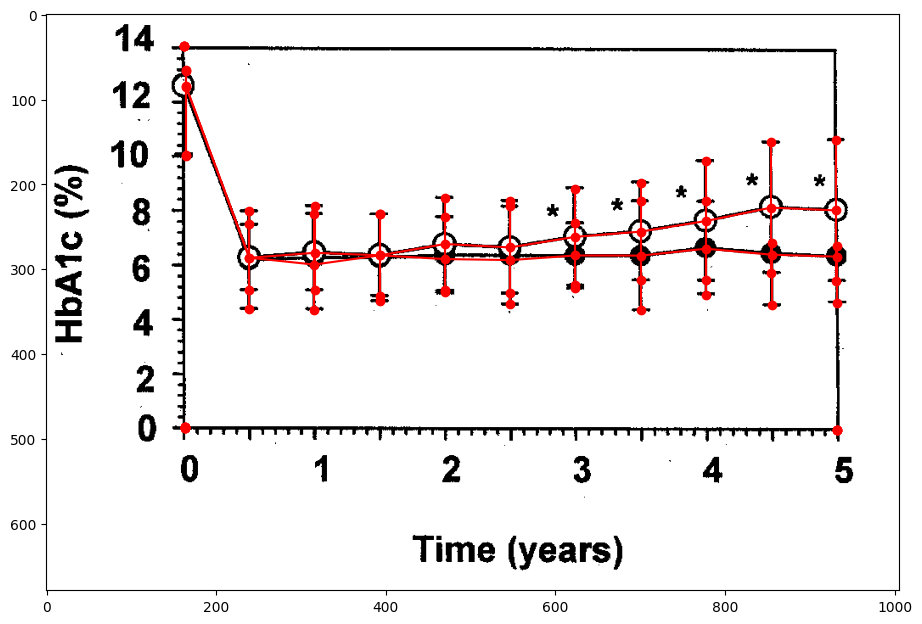

In [212]:
def visualize_sample(idx):
  img = plt.imread(dataset[idx].image_path)
  fig, ax = plt.subplots(figsize=(img.shape[0]//60, img.shape[1]//60))
  ax.imshow(img, cmap='gray')

  for line in dataset[idx].lines:
    x, y = [], []
    for p in line.points:
      if p.label == '':
        x.append(p.x)
        y.append(p.y)
      ax.plot([p.x, p.x], [p.y - p.topBarPixelDistance, p.y + p.bottomBarPixelDistance], color='red', marker='o')
    ax.plot(x, y, color='red', marker='o')
    # ax.set_axis_off()
  plt.show()

visualize_sample(29)

## Cleaning: Bar height
Conclusion: Remove all points with total bar height > 410

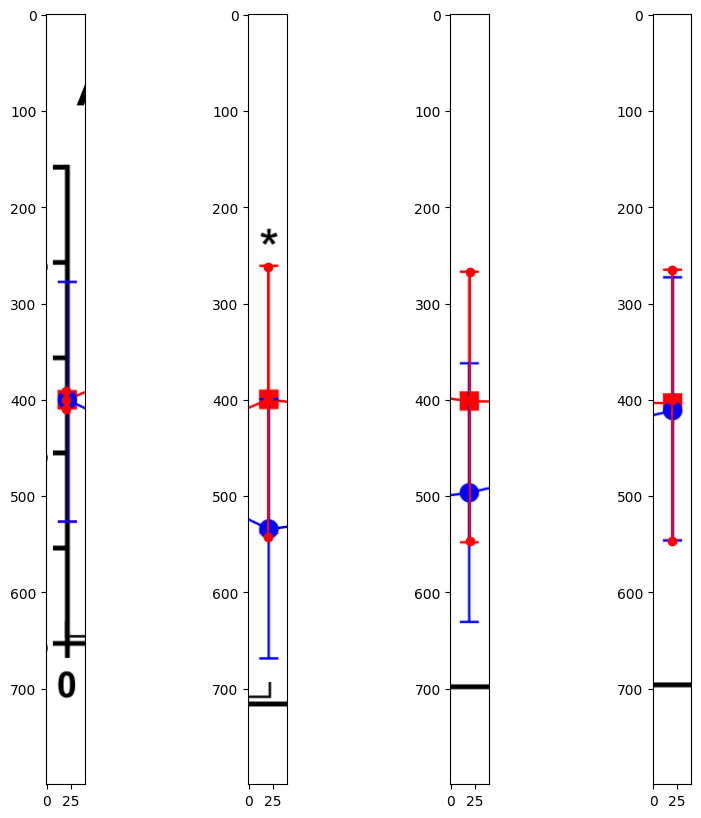

In [197]:
import numpy as np

def visualize_sample_bars(idx, line_no=0):
  img = plt.imread(dataset[idx].image_path)
  line = dataset[idx].lines[line_no]
  valid_points = [p for p in line.points if p.label == '']

  fig, axs = plt.subplots(1, len(valid_points), figsize=(10, 10))

  height_half = 400
  width_half = 20

  for i, p in enumerate(valid_points):
    x = int(p.x)
    y = int(p.y)

    y_start_img = max(0, y - height_half)
    y_end_img = min(img.shape[0], y + height_half)
    x_start_img = max(0, x - width_half)
    x_end_img = min(img.shape[1], x + width_half)

    actual_crop_content = img[y_start_img:y_end_img, x_start_img:x_end_img]

    canvas = np.ones((height_half * 2, width_half * 2, img.shape[2]), dtype=img.dtype)

    canvas_y_start = height_half - (y - y_start_img)
    canvas_y_end = canvas_y_start + actual_crop_content.shape[0]
    canvas_x_start = width_half - (x - x_start_img)
    canvas_x_end = canvas_x_start + actual_crop_content.shape[1]

    canvas[canvas_y_start:canvas_y_end, canvas_x_start:canvas_x_end] = actual_crop_content
    img_cropped = canvas

    axs[i].imshow(img_cropped)
    axs[i].plot([width_half, width_half, width_half], [height_half - p.topBarPixelDistance, height_half, height_half + p.bottomBarPixelDistance], color='red', marker='o')
    # axs[i].set_axis_off()
  plt.show()

visualize_sample_bars(7)

In [198]:
deleted = [
  # incorrect, too large
  "a4fd3ec9-20c5-42d9-952c-23b14f95bb2b", # height: 1082
  "d0dc171b-918f-4d56-81e7-71f845036bc9",
  "3f51a540-6dc4-4563-89e9-1d598771fa19",
  "e886ed99-1aad-4efe-8119-1db7bf407aa0",
  "49a71e97-0215-42f8-b821-d3dcb04eeed7",
  "6fedfc3d-dadf-4dc0-bc05-2c3a2682ccf3",
  "4fed948e-0b77-4830-9be2-827e7f1c51b8", # height: 440
  "a0e95e6e-deb4-4318-a856-d3012ef8be0c",
  "f4bcca67-43f3-4e65-8c86-fc6ec4356357"
]

In [199]:
def bar_height_analysis():
  small, medium, large = [], [], []
  for i, image in enumerate(dataset):
    if image.id in deleted:
      continue
    for line in image.lines:
      for point in line.points:
        height = point.topBarPixelDistance + point.bottomBarPixelDistance
        if height < 10:
          small.append((height, i, image.id))
        elif height < 40:
          medium.append((height, i, image.id))
        else:
          large.append((height, i, image.id))

  print(f"Total small bars: {len(small)}")
  if small:
    min_small = min(small, key=lambda x: x[0])
    max_small = max(small, key=lambda x: x[0])
    print(f"  Smallest height in 'small' category: {min_small[0]} (Image Idx: {min_small[1]}, {min_small[2]})")
    print(f"  Largest height in 'small' category: {max_small[0]} (Image Idx: {max_small[1]}), {max_small[2]})")

  print(f"\nTotal medium bars: {len(medium)}")
  if medium:
    min_medium = min(medium, key=lambda x: x[0])
    max_medium = max(medium, key=lambda x: x[0])
    print(f"  Smallest height in 'medium' category: {min_medium[0]} (Image Idx: {min_medium[1]}, {min_medium[2]})")
    print(f"  Largest height in 'medium' category: {max_medium[0]} (Image Idx: {max_medium[1]}, {max_medium[2]})")

  print(f"\nTotal large bars: {len(large)}")
  if large:
    min_large = min(large, key=lambda x: x[0])
    max_large = max(large, key=lambda x: x[0])
    print(f"  Smallest height in 'large' category: {min_large[0]} (Image Idx: {min_large[1]}, {min_large[2]})")
    print(f"  Largest height in 'large' category: {max_large[0]} (Image Idx: {max_large[1]}, {max_large[2]})")

bar_height_analysis()

Total small bars: 2677
  Smallest height in 'small' category: 0.0 (Image Idx: 0, 043d958d-c6fb-407e-ba05-19ccf09017a2)
  Largest height in 'small' category: 9.999999999999972 (Image Idx: 71), 75fcf4b4-c2df-4b2b-a33a-b45013d2945c)

Total medium bars: 1821
  Smallest height in 'medium' category: 10.0 (Image Idx: 6, 0c180e35-b2fa-4b24-9718-68403f1f41d8)
  Largest height in 'medium' category: 39.999999999999986 (Image Idx: 30, 3041a99a-f851-44df-9114-422ffc016d01)

Total large bars: 1453
  Smallest height in 'large' category: 40.0 (Image Idx: 10, 1423daea-79b4-4de5-a632-7c48bae74a03)
  Largest height in 'large' category: 403.5872497558594 (Image Idx: 70, 75bfe3c5-3e39-46c3-be78-c198482081a8)


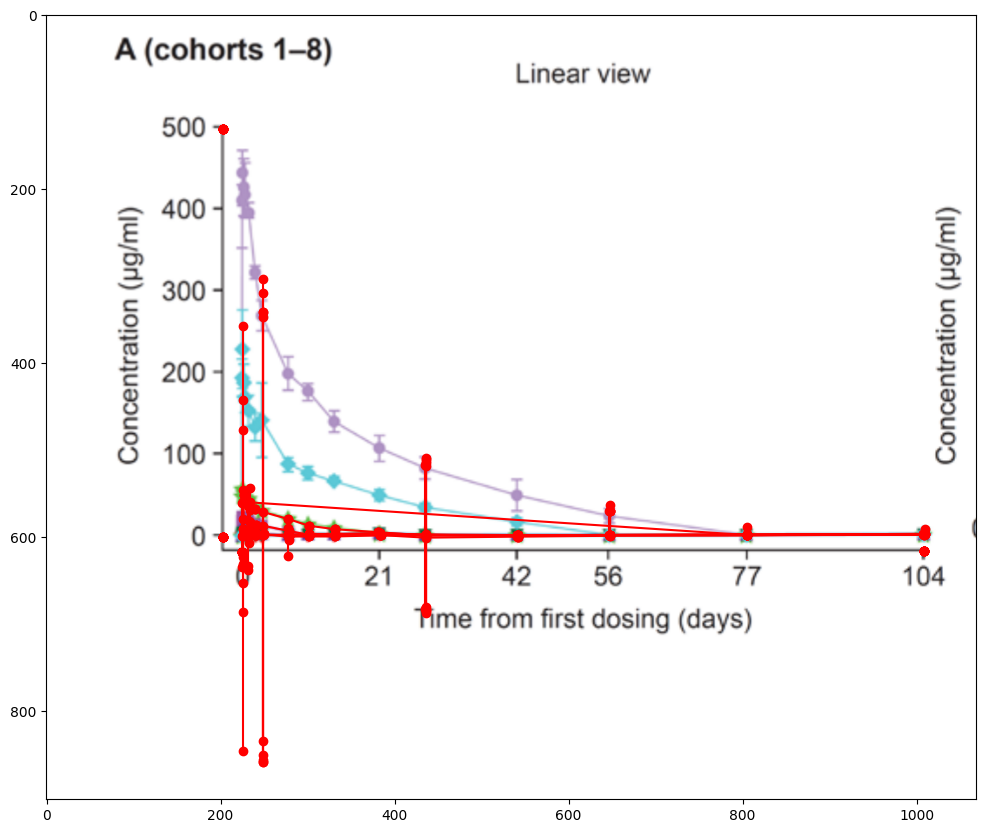

In [152]:
visualize_sample(37)

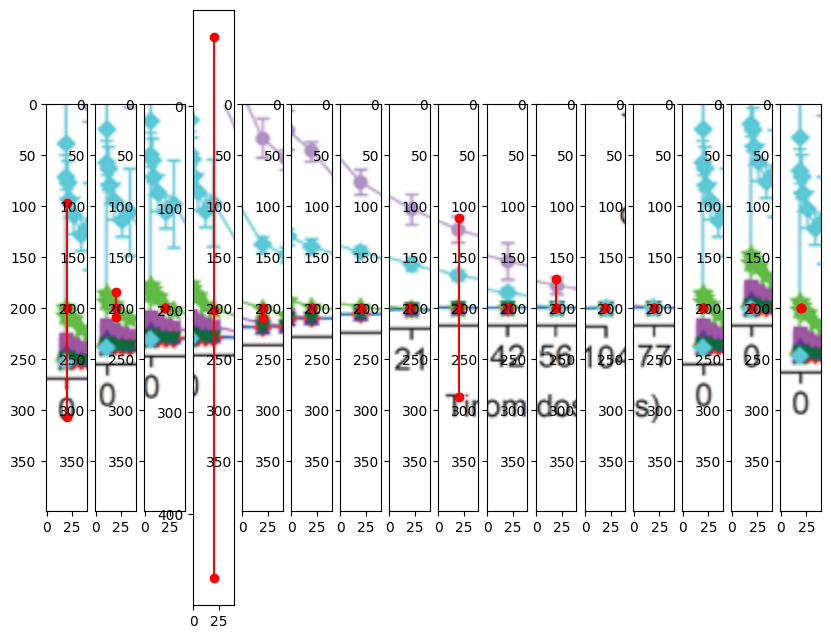

In [153]:
visualize_sample_bars(37)

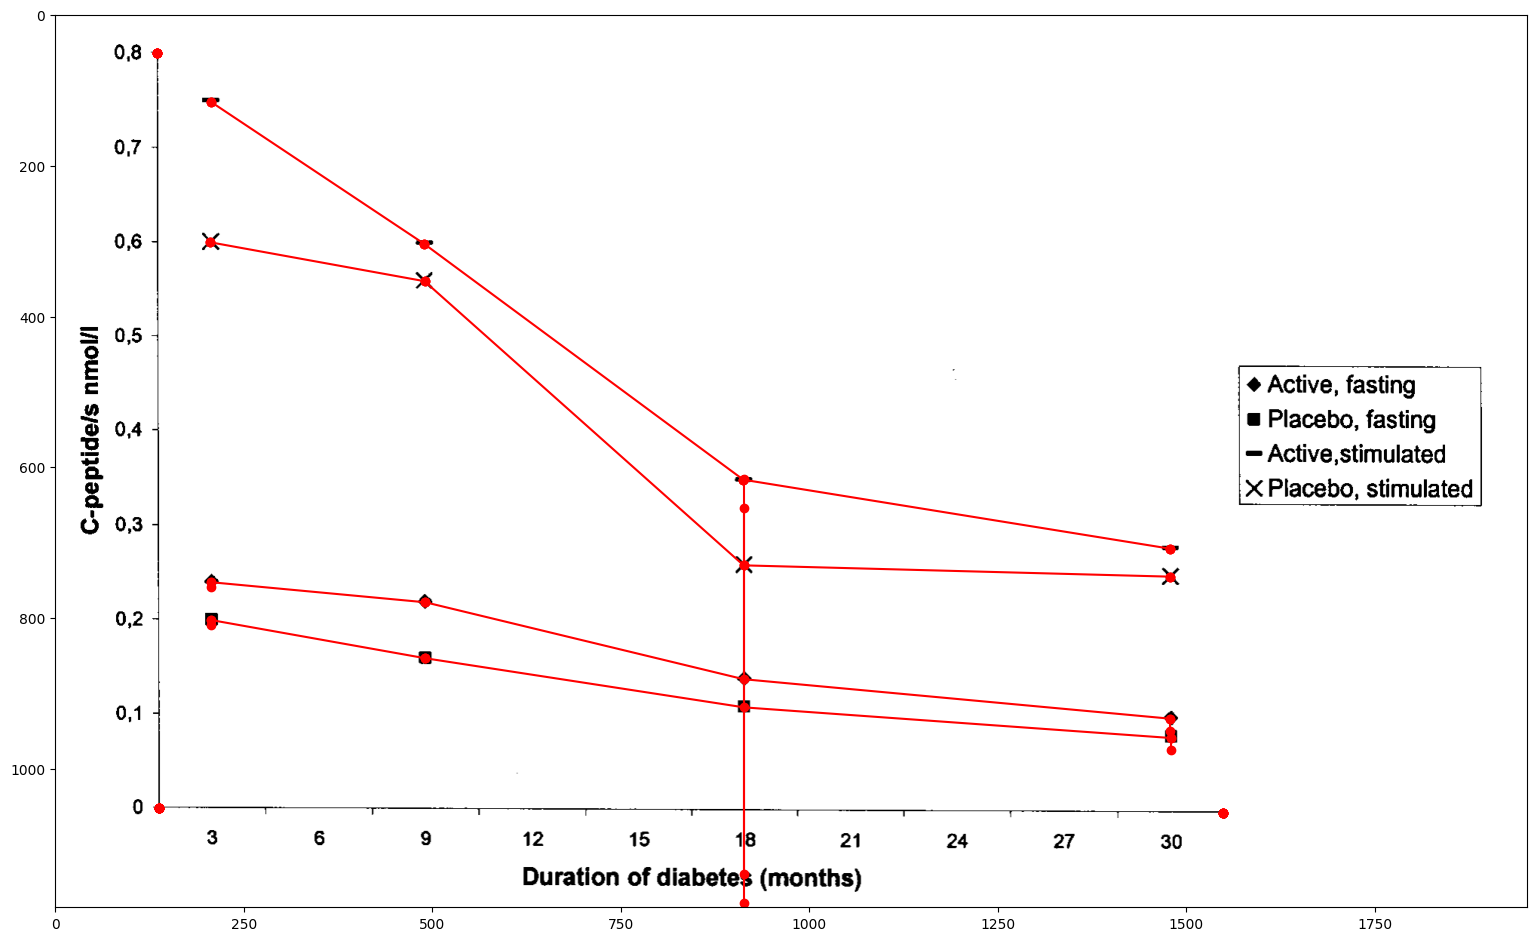

In [156]:
visualize_sample(138)

## Cleaning: Points near phantom points
Conclusion: Points 10 points near phantom points should be cleaned

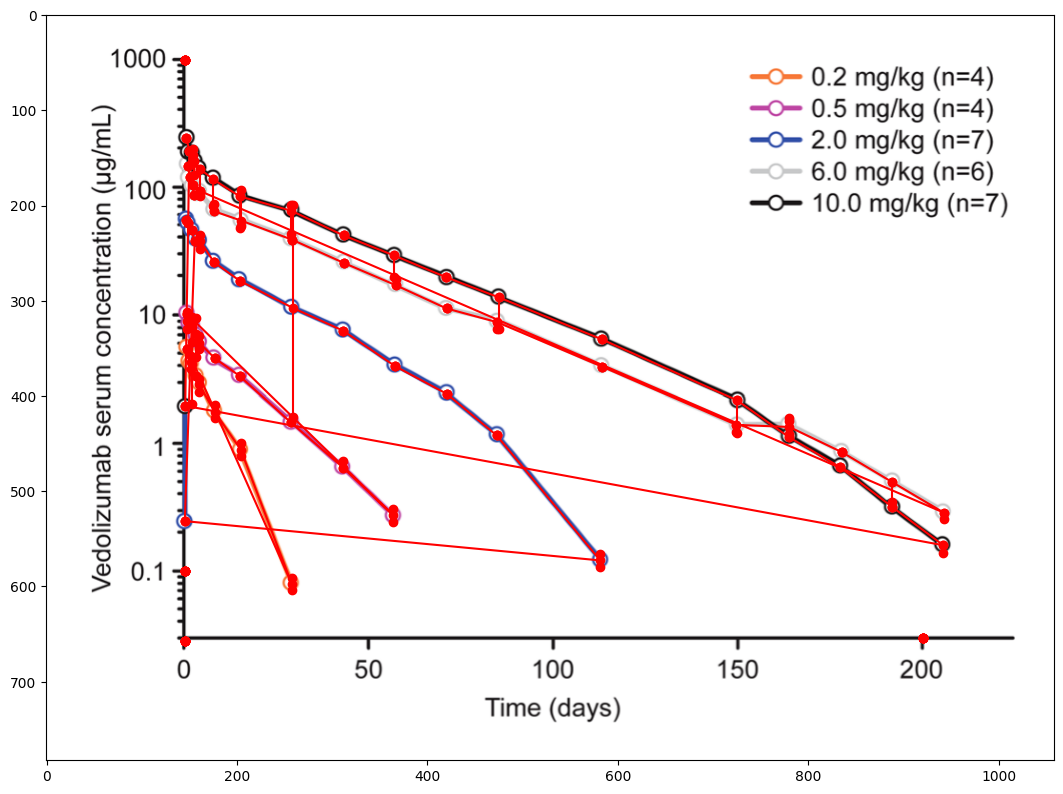

In [236]:
visualize_sample(17)

In [250]:
import math

def count_near_phantom_stats(threshold_distance):
  total_points, total_near_phantom = 0, 0
  for image in dataset:
    phantoms = {(p.x, p.y) for l in image.lines for p in l.points if len(p.label) != 0}
    for line in image.lines:
      for p in line.points:
        if len(p.label) != 0:
          continue
        dist = min([math.sqrt((p.x-x)**2 + (p.y-y)**2) for x,y in phantoms])
        if dist < threshold_distance:
          total_near_phantom += 1
        total_points += 1
  return total_near_phantom

count_near_phantom_stats(10)

115

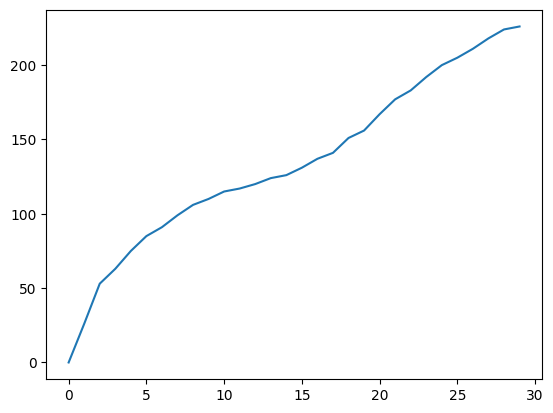

In [249]:
x = list(range(30))
y = [count_near_phantom_stats(i) for i in x]
plt.plot(x, y);

## Cleaning: Filename
Conclusion: All clean

In [252]:
import os

def check_image_for_all_labels_exists():
  does_not_exist = 0
  for image in dataset:
    if not os.path.exists(image.image_path):
      does_not_exist += 1
  print("Does not exist:", does_not_exist)

check_image_for_all_labels_exists()

Does not exist: 0


## Cleaning: Error bar falls within image
Conclusion: 9 violations exist

In [256]:
def check_error_bar_within_image():
  violations = 0
  for image in dataset:
    image_height = plt.imread(image.image_path).shape[0]
    for line in image.lines:
      for p in line.points:
        if p.y-p.topBarPixelDistance < 0 or p.y+p.bottomBarPixelDistance > image_height:
          violations += 1
  return violations

check_error_bar_within_image()

9